# 1D Unsteady Flow Simulation: Solving the St. Venant Equations using the Method of Characteristics (MOC)

**Course:** Advanced Hydraulics

**Audience:** Master's Students in Water Resources Engineering

**Objective:** This hands-on tutorial will guide you through the process of building a 1D hydraulic model to simulate unsteady flow in an open channel. We will use the Method of Characteristics (MOC) on a fixed grid to solve the full St. Venant equations. By the end of this session, you will be able to:

1.  Understand the theoretical basis of the Method of Characteristics.
2.  Discretize the St. Venant equations for a numerical solution.
3.  Implement the MOC algorithm in Python using `numpy`.
4.  Apply appropriate upstream and downstream boundary conditions.
5.  Visualize and interpret the simulation results using `matplotlib`.

## 1. Theoretical Background

Unsteady flow in open channels is described by the **St. Venant equations**, which represent the conservation of mass and momentum.

### 1.1 The St. Venant Equations

For a rectangular channel of constant width $B$, the equations are:

**1. Continuity Equation (Conservation of Mass):**
$$ \frac{\partial y}{\partial t} + V \frac{\partial y}{\partial x} + \frac{A}{B} \frac{\partial V}{\partial x} = 0 $$

Since for a rectangular channel, Area $A = By$ and Top Width $T=B$, we have $A/B = y$. The equation simplifies to:
$$ \frac{\partial y}{\partial t} + V \frac{\partial y}{\partial x} + y \frac{\partial V}{\partial x} = 0 \quad (1)$$

**2. Momentum Equation (Conservation of Momentum):**
$$ \frac{\partial V}{\partial t} + V \frac{\partial V}{\partial x} + g \frac{\partial y}{\partial x} = g(S_0 - S_f) \quad (2)$$

Where:
- $y$: flow depth (m)
- $V$: flow velocity (m/s)
- $x$: distance along the channel (m)
- $t$: time (s)
- $g$: acceleration due to gravity (9.81 m/s²)
- $S_0$: channel bed slope (dimensionless)
- $S_f$: friction slope, estimated by Manning's formula: $S_f = \frac{n^2 V^2}{R_h^{4/3}}$
- $n$: Manning's roughness coefficient
- $R_h$: Hydraulic Radius. For a wide rectangular channel, $R_h \approx y$.

### 1.2 The Method of Characteristics (MOC)

The MOC transforms the two partial differential equations (PDEs) into a set of four ordinary differential equations (ODEs) by finding specific paths (characteristics) in the $x-t$ plane along which the solution is simpler.

We take a linear combination of Eq (1) and (2): $L_1 + \lambda L_2 = 0$. After some mathematical manipulation, we find that this combination becomes an ODE if we choose specific values for $\lambda$. This leads to two sets of equations:

**C+ Characteristic:**
$$ \frac{dV}{dt} + \frac{g}{c} \frac{dy}{dt} = g(S_0 - S_f) \quad \text{along} \quad \frac{dx}{dt} = V+c $$

**C- Characteristic:**
$$ \frac{dV}{dt} - \frac{g}{c} \frac{dy}{dt} = g(S_0 - S_f) \quad \text{along} \quad \frac{dx}{dt} = V-c $$

Where $c = \sqrt{gy}$ is the **celerity** of a small surface wave.

### 1.3 Discretization using a Fixed Grid

We will solve these equations on a fixed grid in the $x-t$ plane. We want to find the solution at a point **P** at time $t+\Delta t$, given the known solutions at time $t$.

<img src="https://i.imgur.com/eB3sV0c.png" width=400 >

*Image credit: Chaudhry, H. M. (2008). Open-channel flow. Springer.* 

The C+ characteristic backtracks from P to a point R, and the C- characteristic backtracks to a point S. Since R and S do not typically fall on grid points, we must **interpolate** the values of $V$ and $y$ at R and S from the known values at grid points A, B, and C.

The finite difference form of the characteristic equations are:

**C+ Equation:**
$$ (V_P - V_R) + \frac{g}{c_R} (y_P - y_R) = g(S_{0} - S_{f,R}) \Delta t $$

**C- Equation:**
$$ (V_P - V_S) - \frac{g}{c_S} (y_P - y_S) = g(S_{0} - S_{f,S}) \Delta t $$

These are two linear equations with two unknowns, $V_P$ and $y_P$. We can solve for them:

$$ y_P = \frac{ (V_R - V_S) + \frac{g}{c_R}y_R + \frac{g}{c_S}y_S - g\Delta t(S_0-S_{f,R}) + g\Delta t(S_0-S_{f,S}) }{ \frac{g}{c_R} + \frac{g}{c_S} } $$

$$ V_P = V_R - \frac{g}{c_R}(y_P - y_R) + g(S_0 - S_{f,R})\Delta t $$

## 2. Setting up the Python Environment and Problem

First, we import the necessary libraries and define the parameters for our channel and simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -- 1. Channel and Flow Parameters --
L = 1000.0      # Channel length (m)
B = 10.0        # Channel width (m) - assuming rectangular
n_manning = 0.015 # Manning's roughness coefficient
S0 = 0.001      # Channel bed slope
g = 9.81        # Gravity

# -- 2. Discretization Parameters --
Nx = 51         # Number of spatial grid points
dx = L / (Nx - 1) # Spatial step size
t_final = 1000  # Total simulation time (s)
CFL = 0.8       # Courant-Friedrichs-Lewy number for stability

# -- 3. Initial Conditions --
# We start with a steady, uniform flow condition.
Q0 = 50.0       # Initial steady flow rate (m^3/s)

# Calculate initial normal depth (y0) using Manning's equation: Q = (1/n)*A*R^(2/3)*S0^(1/2)
# For a wide rectangular channel, A = B*y, R_h approx y. So, Q = (1/n)*B*y*y^(2/3)*S0^(1/2)
# y0 = (Q * n / (B * S0^0.5))^(3/5)
y0 = (Q0 * n_manning / (B * np.sqrt(S0)))**(3.0/5.0)
V0 = Q0 / (B * y0)

print(f"Initial Normal Depth (y0): {y0:.3f} m")
print(f"Initial Velocity (V0): {V0:.3f} m/s")
print(f"Initial Froude Number (Fr0): {V0/np.sqrt(g*y0):.3f}") # Should be subcritical

# -- 4. Set up Grid and Initial Arrays --
x = np.linspace(0, L, Nx)
y = np.full(Nx, y0) # Initialize depth array
V = np.full(Nx, V0) # Initialize velocity array

# Calculate initial time step based on CFL condition
# dt <= CFL * dx / (|V| + c)
c0 = np.sqrt(g * y0)
dt = CFL * dx / (V0 + c0)
print(f"\nChosen Time Step (dt): {dt:.3f} s")

# -- 5. Boundary Conditions --
# Upstream: Inflow hydrograph (flow increases from 50 to 100 m3/s over 300s)
def upstream_bc(t):
    if t < 300:
        return 50.0 + (50.0/300.0) * t
    else:
        return 100.0

# Downstream: Fixed depth (e.g., controlled by a gate or reservoir)
y_downstream = y0 # Keep downstream depth constant


Initial Normal Depth (y0): 1.679 m
Initial Velocity (V0): 2.978 m/s
Initial Froude Number (Fr0): 0.734

Chosen Time Step (dt): 2.274 s


## 3. The MOC Solver Implementation

Now we'll build the main simulation loop. The process at each time step is:

1.  Create temporary arrays `y_new` and `V_new` to store results for the next time step.
2.  **Loop through interior points** (`i` from 1 to `Nx-2`):
    a. Calculate the locations of R and S.
    b. Interpolate to find `y` and `V` at R and S.
    c. Solve the C+ and C- equations for `y_P` and `V_P` and store them in `y_new[i]` and `V_new[i]`.
3.  **Apply Boundary Conditions**:
    a. At the upstream end (`i=0`), use the C- characteristic and the inflow hydrograph to find `y_new[0]` and `V_new[0]`.
    b. At the downstream end (`i=Nx-1`), use the C+ characteristic and the fixed depth condition to find `y_new[Nx-1]` and `V_new[Nx-1]`.
4.  Update the main arrays: `y = y_new`, `V = V_new`.
5.  Store results for later plotting.


In [2]:
t = 0.0
results = {0.0: y.copy()} # Dictionary to store results at different times
plot_times = [100, 200, 400, 800, 1000]
next_plot_time_index = 0

# Main time-stepping loop
while t < t_final:
    # Create new arrays for the next time step
    y_new = np.zeros_like(y)
    V_new = np.zeros_like(V)

    # --- 1. Interior Points --- 
    for i in range(1, Nx - 1):
        # Values at grid point i at time t
        V_i = V[i]
        y_i = y[i]
        c_i = np.sqrt(g * y_i)
        
        # --- C+ Interpolation (for point R) ---
        # Location of R: x_R = x_i - (V_i + c_i) * dt
        # We need to interpolate between points i-1 and i
        x_R = x[i] - (V[i] + np.sqrt(g*y[i])) * dt
        theta_R = (x[i] - x_R) / dx
        V_R = V[i] - theta_R * (V[i] - V[i-1])
        y_R = y[i] - theta_R * (y[i] - y[i-1])
        c_R = np.sqrt(g * y_R)
        Sf_R = n_manning**2 * V_R**2 / (y_R**(4/3)) # Assuming wide channel R_h = y
        
        # --- C- Interpolation (for point S) ---
        # Location of S: x_S = x_i - (V_i - c_i) * dt
        # We need to interpolate between points i and i+1
        x_S = x[i] - (V[i] - np.sqrt(g*y[i])) * dt
        theta_S = (x_S - x[i]) / dx
        V_S = V[i] + theta_S * (V[i+1] - V[i])
        y_S = y[i] + theta_S * (y[i+1] - y[i])
        c_S = np.sqrt(g * y_S)
        Sf_S = n_manning**2 * V_S**2 / (y_S**(4/3))
        
        # --- Solve for y_P and V_P ---
        # Note: Added small epsilon to denominator to avoid division by zero if celerity is near zero
        epsilon = 1e-6
        C_plus = V_R + (g/c_R)*y_R - g*(S0 - Sf_R)*dt
        C_minus = V_S - (g/c_S)*y_S - g*(S0 - Sf_S)*dt
        
        y_new[i] = (C_plus - C_minus) / (g/c_R + g/c_S + epsilon)
        V_new[i] = C_plus - (g/c_R) * y_new[i]
        
    # --- 2. Boundary Conditions ---
    
    # -- Upstream Boundary (i=0) --
    # Use C- characteristic from (1) to (0) and the inflow hydrograph Q(t)
    # V_new[0] * (B * y_new[0]) = Q_upstream(t+dt)
    Q_up = upstream_bc(t + dt)
    
    # From C- characteristic (point S is at i=1)
    V_S_bc = V[1]
    y_S_bc = y[1]
    c_S_bc = np.sqrt(g * y_S_bc)
    Sf_S_bc = n_manning**2 * V_S_bc**2 / (y_S_bc**(4/3))
    
    # We have two equations for V_new[0] and y_new[0]:
    # 1) V_new[0] = V_S_bc + (g/c_S_bc)*(y_new[0] - y_S_bc) + g*(S0 - Sf_S_bc)*dt (from MOC)
    # 2) V_new[0] = Q_up / (B * y_new[0]) (from BC)
    # This requires solving a non-linear equation for y_new[0]. We can use a simple iterative approach (Newton-Raphson is better, but this is simpler for a tutorial).
    # Let's rearrange: f(y) = K1*y + K2/y - K3 = 0. We'll simplify and solve for V first.
    C_up = V_S_bc - (g/c_S_bc)*y_S_bc - g*(S0 - Sf_S_bc)*dt
    # V_new[0] = C_up + (g/c_S_bc) * y_new[0]
    # Substituting into BC: (C_up + (g/c_S_bc) * y_new[0]) * B * y_new[0] = Q_up
    # This is a quadratic equation in y_new[0]. For simplicity, we'll use an explicit update, which is often stable enough.
    y_new[0] = y[0] # Guess next depth is same as current
    for _ in range(3): # Iterate a few times to converge
        V_new[0] = C_up + (g / c_S_bc) * y_new[0]
        y_new[0] = Q_up / (B * V_new[0])

    # Final velocity calculation based on converged depth
    V_new[0] = Q_up / (B * y_new[0])
    
    # -- Downstream Boundary (i=Nx-1) --
    # Use C+ characteristic from (Nx-2) to (Nx-1) and fixed depth condition
    y_new[Nx - 1] = y_downstream
    
    # From C+ characteristic (point R is at i=Nx-2)
    V_R_bc = V[Nx-2]
    y_R_bc = y[Nx-2]
    c_R_bc = np.sqrt(g * y_R_bc)
    Sf_R_bc = n_manning**2 * V_R_bc**2 / (y_R_bc**(4/3))
    
    # V_new[Nx-1] = V_R_bc - (g/c_R_bc)*(y_new[Nx-1] - y_R_bc) + g*(S0 - Sf_R_bc)*dt
    V_new[Nx-1] = V_R_bc - (g / c_R_bc) * (y_new[Nx-1] - y_R_bc) + g * (S0 - Sf_R_bc) * dt
    
    # --- 3. Update state and time ---
    y = y_new.copy()
    V = V_new.copy()
    t += dt
    
    # --- 4. Store results for plotting ---
    if next_plot_time_index < len(plot_times) and t >= plot_times[next_plot_time_index]:
        results[plot_times[next_plot_time_index]] = y.copy()
        print(f"... Stored results at t = {t:.1f} s")
        next_plot_time_index += 1

print(f"\nSimulation finished at t = {t:.1f} s.")

... Stored results at t = 100.1 s
... Stored results at t = 200.1 s
... Stored results at t = 400.2 s
... Stored results at t = 800.4 s
... Stored results at t = 1000.5 s

Simulation finished at t = 1000.5 s.


C:\Users\Ripple\AppData\Local\Temp\ipykernel_12192\1449600963.py:26: RuntimeWarning: invalid value encountered in sqrt
  c_R = np.sqrt(g * y_R)
C:\Users\Ripple\AppData\Local\Temp\ipykernel_12192\1449600963.py:27: RuntimeWarning: invalid value encountered in scalar power
  Sf_R = n_manning**2 * V_R**2 / (y_R**(4/3)) # Assuming wide channel R_h = y


## 4. Visualizing the Results

Now that the simulation is complete, we can visualize the results to understand the behavior of the flood wave.

### 4.1 Water Surface Profiles at Different Times

This plot shows a "snapshot" of the water surface along the entire channel length at specific moments in time. We can see the flood wave created by the upstream hydrograph propagating downstream.

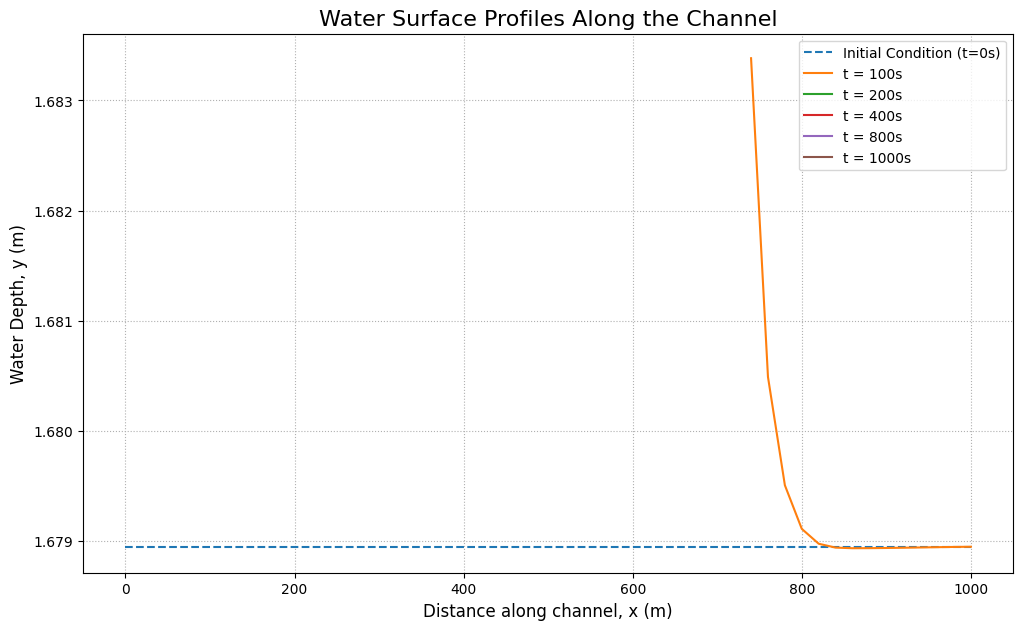

In [3]:
plt.figure(figsize=(12, 7))

for time, depth_profile in results.items():
    if time == 0:
        label = f"Initial Condition (t={time:.0f}s)"
        ls = '--'
    else:
        label = f"t = {time:.0f}s"
        ls = '-'
    plt.plot(x, depth_profile, label=label, linestyle=ls)

plt.title('Water Surface Profiles Along the Channel', fontsize=16)
plt.xlabel('Distance along channel, x (m)', fontsize=12)
plt.ylabel('Water Depth, y (m)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

### 4.2 Hydrographs at Different Locations

This plot shows how the flow rate changes over time at specific points in the channel (upstream, midpoint, and downstream). This helps us see the **translation** (movement) and **attenuation** (flattening) of the flood wave as it travels.

C:\Users\Ripple\AppData\Local\Temp\ipykernel_12192\1388666510.py:27: RuntimeWarning: invalid value encountered in sqrt
  c_R = np.sqrt(g * y_R)
C:\Users\Ripple\AppData\Local\Temp\ipykernel_12192\1388666510.py:28: RuntimeWarning: invalid value encountered in scalar power
  Sf_R = n_manning**2 * V_R**2 / (y_R**(4/3))


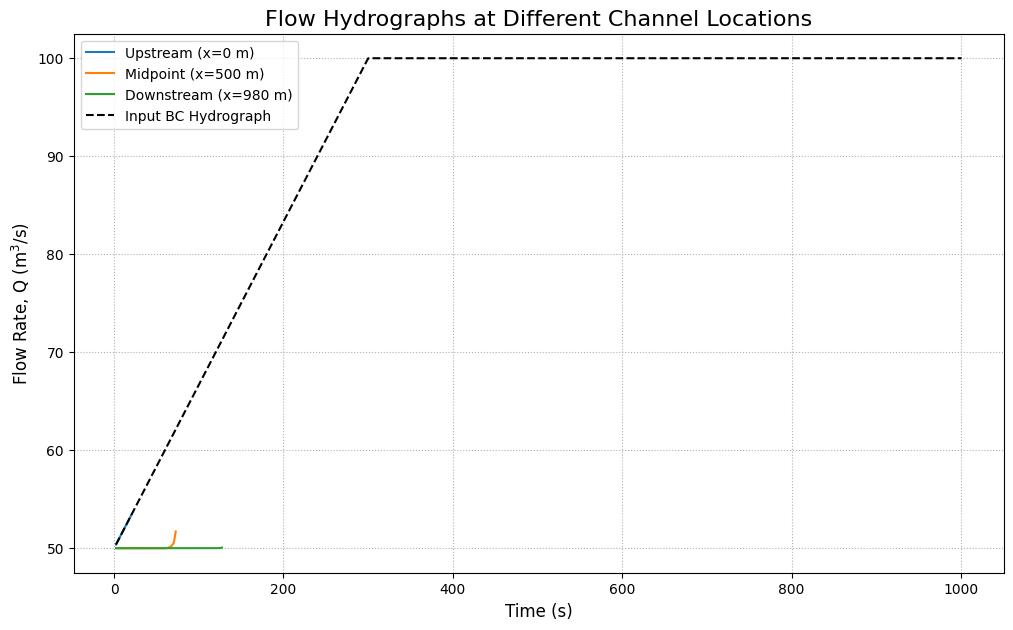

In [4]:
# To plot hydrographs, we need to re-run the simulation and store flow Q over time
# at specific locations.

# Re-initialize
y = np.full(Nx, y0)
V = np.full(Nx, V0)
t = 0.0

# Locations to track hydrographs
loc_upstream = 0
loc_mid = int(Nx/2)
loc_downstream = Nx-2 # -2 to avoid the very last node which has fixed depth

time_history = []
Q_history = {'upstream': [], 'midpoint': [], 'downstream': []}

# Main simulation loop for collecting hydrograph data
while t < t_final:
    # (The MOC solver code from the previous cell is copied here)
    y_new = np.zeros_like(y)
    V_new = np.zeros_like(V)
    for i in range(1, Nx - 1):
        x_R = x[i] - (V[i] + np.sqrt(g*y[i])) * dt
        theta_R = (x[i] - x_R) / dx
        V_R = V[i] - theta_R * (V[i] - V[i-1])
        y_R = y[i] - theta_R * (y[i] - y[i-1])
        c_R = np.sqrt(g * y_R)
        Sf_R = n_manning**2 * V_R**2 / (y_R**(4/3))
        x_S = x[i] - (V[i] - np.sqrt(g*y[i])) * dt
        theta_S = (x_S - x[i]) / dx
        V_S = V[i] + theta_S * (V[i+1] - V[i])
        y_S = y[i] + theta_S * (y[i+1] - y[i])
        c_S = np.sqrt(g * y_S)
        Sf_S = n_manning**2 * V_S**2 / (y_S**(4/3))
        epsilon = 1e-6
        C_plus = V_R + (g/c_R)*y_R - g*(S0 - Sf_R)*dt
        C_minus = V_S - (g/c_S)*y_S - g*(S0 - Sf_S)*dt
        y_new[i] = (C_plus - C_minus) / (g/c_R + g/c_S + epsilon)
        V_new[i] = C_plus - (g/c_R) * y_new[i]
    Q_up = upstream_bc(t + dt)
    V_S_bc = V[1]; y_S_bc = y[1]; c_S_bc = np.sqrt(g * y_S_bc); Sf_S_bc = n_manning**2 * V_S_bc**2 / (y_S_bc**(4/3))
    C_up = V_S_bc - (g/c_S_bc)*y_S_bc - g*(S0 - Sf_S_bc)*dt
    y_new[0] = y[0]
    for _ in range(3): V_new[0] = C_up + (g / c_S_bc) * y_new[0]; y_new[0] = Q_up / (B * V_new[0]) if V_new[0]!=0 else 0
    V_new[0] = Q_up / (B * y_new[0]) if y_new[0]!=0 else 0
    y_new[Nx - 1] = y_downstream
    V_R_bc = V[Nx-2]; y_R_bc = y[Nx-2]; c_R_bc = np.sqrt(g * y_R_bc); Sf_R_bc = n_manning**2 * V_R_bc**2 / (y_R_bc**(4/3))
    V_new[Nx-1] = V_R_bc - (g / c_R_bc) * (y_new[Nx-1] - y_R_bc) + g * (S0 - Sf_R_bc) * dt
    y = y_new.copy(); V = V_new.copy(); t += dt
    
    # Store data for hydrographs
    time_history.append(t)
    Q_history['upstream'].append(V[loc_upstream] * B * y[loc_upstream])
    Q_history['midpoint'].append(V[loc_mid] * B * y[loc_mid])
    Q_history['downstream'].append(V[loc_downstream] * B * y[loc_downstream])

# Plotting the hydrographs
plt.figure(figsize=(12, 7))
plt.plot(time_history, Q_history['upstream'], label=f'Upstream (x={x[loc_upstream]:.0f} m)')
plt.plot(time_history, Q_history['midpoint'], label=f'Midpoint (x={x[loc_mid]:.0f} m)')
plt.plot(time_history, Q_history['downstream'], label=f'Downstream (x={x[loc_downstream]:.0f} m)')

# Also plot the input hydrograph for comparison
input_Q = [upstream_bc(t_val) for t_val in time_history]
plt.plot(time_history, input_Q, 'k--', label='Input BC Hydrograph')

plt.title('Flow Hydrographs at Different Channel Locations', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Flow Rate, Q (m$^3$/s)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

## 5. Conclusion and Further Exploration

In this tutorial, we have successfully implemented the Method of Characteristics on a fixed grid to solve the St. Venant equations for unsteady flow. We simulated the propagation of a flood wave resulting from an upstream inflow hydrograph and observed its movement and attenuation.

### For further practice and exploration, you can try:

1.  **Different Boundary Conditions:**
    - Implement a **rating curve** as the downstream boundary condition, where $Q = f(y)$. This is more realistic for many rivers.
    - Try a different inflow hydrograph, such as a triangular or sinusoidal one.
2.  **Channel Geometry:**
    - Modify the code to handle a **trapezoidal channel**. This will require changing the calculations for Area ($A$), Top Width ($T$), and Hydraulic Radius ($R_h$).
    - Implement a non-prismatic channel where the width $B$ or slope $S_0$ changes with distance $x$.
3.  **Numerical Scheme:**
    - Compare the MOC results with an explicit finite difference scheme like the **MacCormack scheme**. Analyze differences in stability, accuracy, and computational effort.
4.  **Visualization:**
    - Use `matplotlib.animation` to create a dynamic animation of the water surface profile evolving over time.